# **Imports**

In [1]:
import pandas as pd
from sklearn import datasets
import numpy as np
import math
import matplotlib.pyplot as plt
from K_means import *
from spectral_fonctions import *
from sklearn.datasets import make_blobs
from numpy import dot
from numpy.linalg import norm
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize
from scipy.sparse.linalg import eigs, eigsh
from scipy.spatial.distance import cdist
from sklearn.impute import KNNImputer
from tqdm import tqdm 

# **Data imports**

## Blob

In [2]:
# generate synthetic data

# parameters
n_samples = 200
n_features = 15
n_clusters = 3

X, y, centers= make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42, return_centers=True)

sc = StandardScaler()
sc.fit(X)
X_std= sc.transform(X)

df = pd.DataFrame(X_std)
df['True_Label'] = y
df_centers = pd.DataFrame(centers)

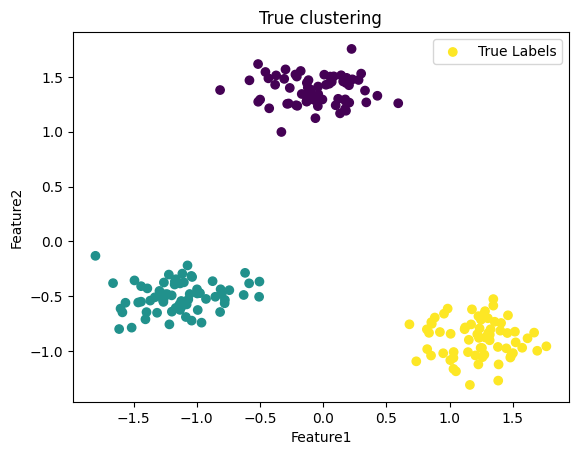

In [3]:
# visualize true clustering (we project on the first two dimensions)
plt.scatter(df[0], df[1], c=df['True_Label'], cmap='viridis', label='True Labels')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('True clustering')
plt.legend()
plt.show()

# **Functions**

In [4]:
def create_test_dataset_missing_data(d: int, n_points: int, mu_list: list, p: float) -> np._typing.NDArray:
    # return K-mixture model with n points in each cluster and delete data with proportion p for each point
    K = len(mu_list)
    X = [0.5 * np.random.randn(d, n_points) + mu_list[k][:, np.newaxis] for k in range(K)]
    X = np.hstack(X)
    mask = np.random.binomial(1, p, (d, len(mu_list) * n_points))
    X[np.where(mask)] = np.nan
    true_clusters = np.hstack([np.full(n_points, k, dtype=np.int8) for k in range(K)])
    return X, true_clusters

In [5]:
def compute_confusion_matrix(clusters:np._typing.NDArray, true_clusters:np._typing.NDArray, k:int)->np._typing.NDArray:
    #  at index i, j: number of elements of cluster i classified as being in cluster j
    N = clusters.shape[0]
    confusion_matrix = np.zeros((k, k))
    for i in range(N):
        confusion_matrix[true_clusters[i], clusters[i]] += 1
    return confusion_matrix

In [6]:
def inpute_data(X, k):
    # Inpute the data which misses values with a k-nearest neighboor search
    imputer = KNNImputer(n_neighbors=k)
    return imputer.fit_transform(X)

# **Measures**

In [7]:
d = n_features
K = n_clusters
n = n_samples
N = n*K

In [8]:
mu_list = list(centers)

In [ ]:
missing_data_proportion=[1e-2, 5*1e-2, 1e-1, 2.5*1e-1, 5*1e-1, 7.5*1e-1]

nbr_samples = 10

number_correctly_classified_regular={p: np.zeros(K) for p in missing_data_proportion}
number_correctly_classified_spectral={p: np.zeros(K) for p in missing_data_proportion}
number_correctly_classified_pca={p: np.zeros(K) for p in missing_data_proportion}


for it_samples in tqdm(range(nbr_samples)):

    kmeans_regular = {p: generalized_Kmeans(K, 'forgy', epochs=10) for p in missing_data_proportion}
    kmeans_pca = {p: generalized_Kmeans(K, 'guided_PCA', epochs=2) for p in missing_data_proportion}
    confusion_matrix_regular = dict()
    confusion_matrix_spectral = dict()
    confusion_matrix_pca = dict()
    
    for p in missing_data_proportion:

        X, true_clusters = create_test_dataset_missing_data(d, n, mu_list, p)
        X = inpute_data(X, 5)

        # Kmeans++
        kmeans_regular[p].fit(X.transpose())
        clusters_regular = kmeans_regular[p].predict(X.transpose())
        clusters_regular = np.round(clusters_regular).astype(int)
        confusion_matrix_regular[p] = compute_confusion_matrix(clusters_regular, true_clusters, K)
        number_correctly_classified_regular[p] = number_correctly_classified_regular[p]+np.sum(np.max(confusion_matrix_regular[p], axis=1))
        
        # spectral Kmeans
        clusters_spectral = final_spectral_clustering_rw(X.transpose(), euclidian_similarity_function, 5, K, True, compute_matrix_U_ARPACK)
        clusters_spectral = np.round(clusters_spectral).astype(int)
        confusion_matrix_spectral[p] = compute_confusion_matrix(clusters_spectral, true_clusters, K)
        number_correctly_classified_spectral[p] = number_correctly_classified_spectral[p]+np.sum(np.max(confusion_matrix_spectral[p], axis=1))

        # PCA-Guided Kmeans
        kmeans_pca[p].fit(X.transpose())
        clusters_pca = kmeans_pca[p].predict(X.transpose())
        clusters_pca = np.round(clusters_pca).astype(int)
        confusion_matrix_pca[p] = compute_confusion_matrix(clusters_pca, true_clusters, K)
        number_correctly_classified_pca[p] = number_correctly_classified_pca[p]+np.sum(np.max(confusion_matrix_pca[p], axis=1))

for p in missing_data_proportion:

    number_correctly_classified_regular[p]/=nbr_samples
    number_correctly_classified_spectral[p]/=nbr_samples
    number_correctly_classified_pca[p]/=nbr_samples

print(number_correctly_classified_regular)
print(number_correctly_classified_spectral)
print(number_correctly_classified_pca)


In [10]:
print(number_correctly_classified_regular)
print(number_correctly_classified_spectral)
print(number_correctly_classified_pca)

{0.01: array([9000., 9000., 9000.]), 0.05: array([8400., 8400., 8400.]), 0.1: array([8400., 8400., 8400.]), 0.25: array([8385., 8385., 8385.]), 0.5: array([7865., 7865., 7865.]), 0.75: array([4260., 4260., 4260.])}
{0.01: array([8352., 8352., 8352.]), 0.05: array([7875., 7875., 7875.]), 0.1: array([7499., 7499., 7499.]), 0.25: array([7878., 7878., 7878.]), 0.5: array([7044., 7044., 7044.]), 0.75: array([7453., 7453., 7453.])}
{0.01: array([8400., 8400., 8400.]), 0.05: array([8400., 8400., 8400.]), 0.1: array([8400., 8400., 8400.]), 0.25: array([8384., 8384., 8384.]), 0.5: array([7862., 7862., 7862.]), 0.75: array([4260., 4260., 4260.])}


In [11]:
np.savetxt('miss reg', list(number_correctly_classified_regular.values()))
np.savetxt('miss spec', list(number_correctly_classified_spectral.values()))
np.savetxt('miss pca', list(number_correctly_classified_pca.values()))

In [12]:
list(number_correctly_classified_spectral.keys())

[0.01, 0.05, 0.1, 0.25, 0.5, 0.75]

In [13]:
np.array(list(number_correctly_classified_spectral.values())).flatten()

array([8352., 8352., 8352., 7875., 7875., 7875., 7499., 7499., 7499.,
       7878., 7878., 7878., 7044., 7044., 7044., 7453., 7453., 7453.])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


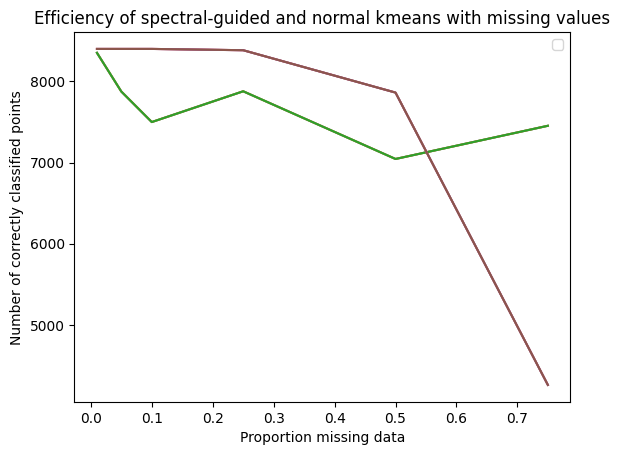

In [18]:
#plt.plot(list(number_correctly_classified_regular.keys()), list(number_correctly_classified_regular.values())) #, label = 'Regular Kmeans')
plt.plot(list(number_correctly_classified_spectral.keys()), list(number_correctly_classified_spectral.values())) #, label = 'Spectral clustering')
plt.plot(list(number_correctly_classified_pca.keys()), list(number_correctly_classified_pca.values())) #, label = 'Guided PCA')
plt.xlabel("Proportion missing data")
plt.ylabel("Number of correctly classified points")
plt.title("Efficiency of spectral-guided and normal kmeans with missing values")
plt.legend()
plt.show()